# A graph-embedded deep feedforward network for disease outcome

classification and feature selection using gene expression data

CSI 4106 - Fall 2025

Marcel Turcotte (School of Electrical Engineering and Computer Science,
University of Ottawa)  
2025-10-26

In this notebook, we aim to partially replicate the study conducted by
Kong & Yu focusing on synthetic data generation.

-   Kong, Y. & Yu, T. (2018). A graph-embedded deep feedforward network
    for disease outcome classification and feature selection using gene
    expression data. *Bioinformatics (Oxford, England)*, *34*(21),
    3727–3737.

We constructed a dataset comprising 5000 attributes, of which only 40
are relevant to determining the value of `y`. Our results demonstrate
that a neural network with a single hidden layer containing just one
node is capable of identifying 20 of these 40 critical attributes when
using $l_1$ and $l_2$ regularization. This approach yields excellent
classification performance.

# Summary of Work

-   Gene expression data poses a challenge in predictive modeling due to
    the small number of samples compared to the large number of
    features.
-   This disparity, known as the ‘n \<\< p’ problem, hinders the
    application of deep learning techniques for disease outcome
    classification.
-   Sparse learning using external gene network information is a
    potential solution but remains challenging due to the vast number of
    features and limited training samples.
-   The scale-free structure of gene networks complicates the use of
    convolutional neural networks.
-   Kong & Yu proposed a Graph-Embedded Deep Feedforward Networks
    (GEDFN) integrating external relational information into deep neural
    network architecture.

# Prepration

This section regroups all the necessary import statements.

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx

from scipy.stats import multivariate_normal

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, callbacks

# Synthetic data generation

Gene expression data is produced under the assumption that the
expression levels of adjacent genes within a gene network exhibit
correlation.

First, a scale-free graph is generated using the preferential attachment
algorithm proposed by Barabási–Albert.

Let’s generate and visualize a small network.

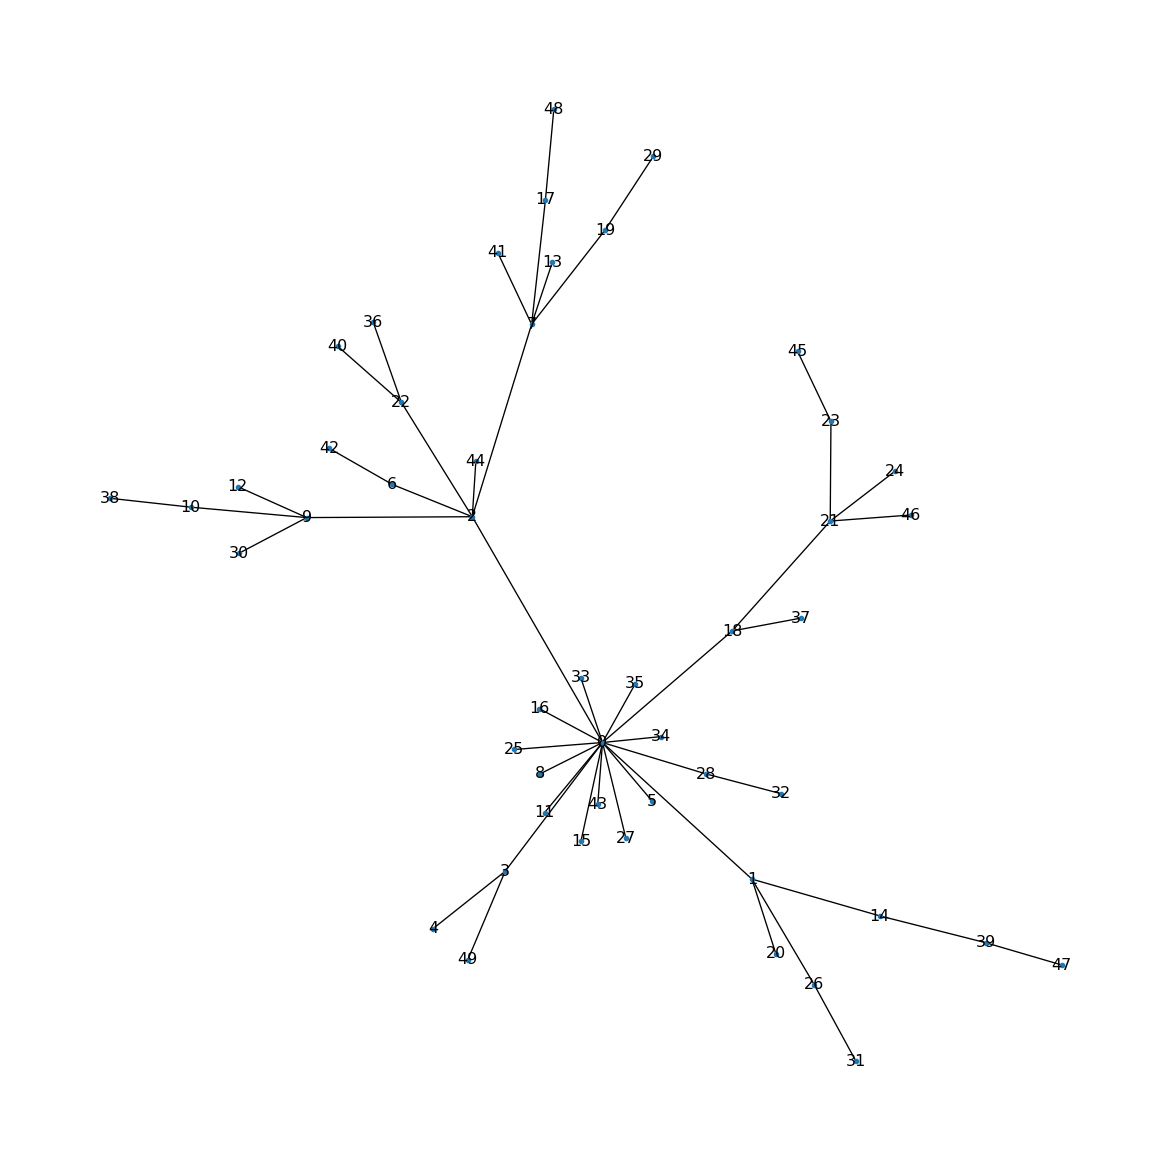

In [3]:
p = 50  # number of features (genes)
m = 1   # number of edges to attach from a new node to existing nodes.

G = nx.barabasi_albert_graph(p, m, seed=42)

pos = nx.spring_layout(G, k=0.1, iterations=100)  # Adjust k as needed
plt.figure(figsize=(12, 12))
nx.draw(G, pos, node_size=10, with_labels=True, labels={node: node for node in G.nodes()})
plt.show()

Analogous to biological networks, certain nodes exhibit a high degree of
connectivity, thereby forming hubs.

We will now implement the necessary functions for generating gene
expression data, grounded in a graph framework and the previously
outlined assumptions.

In [4]:
def generate_scale_free_graph(p, m=1):
    """
    Generate a scale-free graph using the Barabási–Albert model.
    
    Args:
        p (int): Number of nodes (features).
        m (int): Number of edges to attach from a new node to existing nodes.
    
    Returns:
        G (networkx.Graph): A scale-free network.
    """
    G = nx.barabasi_albert_graph(p, m, seed=42)
    return G

def compute_distance_matrix(G):
    """
    Compute the pairwise shortest-path distance matrix D for graph G.
    
    Args:
        G (networkx.Graph): The feature graph.
    
    Returns:
        D (np.ndarray): A (p x p) matrix of shortest-path distances.
    """
    p = G.number_of_nodes()
    D = np.zeros((p, p))
    for i in range(p):
        lengths = nx.single_source_shortest_path_length(G, i)
        for j in range(p):
            D[i, j] = lengths.get(j, np.inf)
    return D

def generate_covariance_matrix(D, decay=0.7):
    """
    Generate a covariance matrix R from the distance matrix D.
    
    Args:
        D (np.ndarray): Distance matrix.
        decay (float): Decay factor; R[i,j] = decay^(D[i,j]).
    
    Returns:
        R (np.ndarray): Covariance matrix.
    """
    R = np.power(decay, D)
    np.fill_diagonal(R, 1.0)
    return R

def select_true_predictors(G, p0, s0=0.0):
    """
    Select true predictors based on the feature graph.
    
    The method selects nodes with high degree (cores) and includes some of their neighbors.
    
    Args:
        G (networkx.Graph): Feature graph.
        p0 (int): Total number of true predictors to select.
        s0 (float): Proportion of 'singletons' amongst the true predictors.
    
    Returns:
        true_idx (np.ndarray): Array of indices for true predictors.
    """
    degrees = dict(G.degree())
    # Sort nodes by degree (highest first)
    sorted_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)
    
    # Choose cores: for example, choose k = max(1, p0//20) top nodes
    k = max(1, p0 // 20)
    cores = [node for node, deg in sorted_nodes[:k]]

    # Determine the number of singletons
    nb_singletons = int(np.ceil(s0 * p0))

    # Remove singletons from the total number of predictors
    p0 -= nb_singletons
    
    true_predictors = set(cores)
    # Add neighbors of each core until we have p0 predictors
    for core in cores:
        neighbors = list(G.neighbors(core))
        np.random.shuffle(neighbors)
        for neighbor in neighbors:
            if len(true_predictors) < p0:
                true_predictors.add(neighbor)
            else:
                break
        if len(true_predictors) >= p0:
            break
    # If not enough, add additional high-degree nodes
    for node, deg in sorted_nodes:
        if len(true_predictors) < p0:
            true_predictors.add(node)
        else:
            break

    while nb_singletons > 0:
        singleton = np.random.choice(list(G.nodes()))
        if singleton not in true_predictors:
            true_predictors.add(singleton)
            nb_singletons -= 1

    true_idx = np.array(list(true_predictors))[:p0]
    return true_idx

def generate_outcome(X, true_idx, b_range=(0.1, 0.2), threshold=0.5, link='sigmoid'):
    """
    Generate binary outcome variables using a generalized linear model.
    
    Args:
        X (np.ndarray): Input data matrix (n x p).
        true_idx (np.ndarray): Indices of true predictors.
        b_range (tuple): Range for sampling coefficients.
        threshold (float): Threshold for converting probabilities to binary outcomes.
        link (str): Link function ('sigmoid' or 'tanh_quad').
        
    Returns:
        y (np.ndarray): Binary outcome vector (n,).
        b (np.ndarray): Coefficients for true predictors.
        b0 (float): Intercept.
        prob (np.ndarray): Computed probabilities.
    """
    p0 = len(true_idx)
    # Sample coefficients uniformly from b_range
    b = np.random.uniform(b_range[0], b_range[1], size=p0)
    # Randomly flip signs (to allow both positive and negative effects)
    signs = np.random.choice([-1, 1], size=p0)
    b = b * signs
    b0 = np.random.uniform(b_range[0], b_range[1])
    
    # Compute linear combination for each sample
    linear_term = np.dot(X[:, true_idx], b) + b0
    
    if link == 'sigmoid':
        prob = 1 / (1 + np.exp(linear_term)) # MT: was np.exp(-linear_term)
    elif link == 'tanh_quad':
        # Example non-monotone function: weighted tanh plus quadratic, then min-max scaling.
        raw = 0.7 * np.tanh(linear_term) + 0.3 * (linear_term ** 2)
        raw_min, raw_max = raw.min(), raw.max()
        if raw_max > raw_min:
            prob = (raw - raw_min) / (raw_max - raw_min)
        else:
            prob = np.zeros_like(raw)
    else:
        raise ValueError("Unknown link function.")
    
    # Generate binary outcomes by thresholding the probabilities
    y = (prob > threshold).astype(int)
    return y, b, b0, prob

def generate_synthetic_data(n=400, p=5000, p0=40, s0=0.0, decay=0.7, m=1, link='sigmoid',
                            b_range=(0.1, 0.2), threshold=0.5, random_seed=42):
    """
    Generate synthetic gene expression data and binary outcomes as described in Kong & Yu (2018).
    
    Args:
        n (int): Number of samples.
        p (int): Number of features (genes).
        p0 (int): Number of true predictors.
        decay (float): Decay factor for covariance matrix.
        m (int): Number of edges to attach from a new node in the Barabási–Albert model.
        link (str): Link function ('sigmoid' or 'tanh_quad').
        b_range (tuple): Range for sampling coefficients.
        threshold (float): Threshold for binary outcome generation.
        random_seed (int): Random seed for reproducibility.
    
    Returns:
        X (np.ndarray): Generated input data (n x p).
        y (np.ndarray): Binary outcomes (n,).
        true_idx (np.ndarray): Indices of true predictors.
        R (np.ndarray): Covariance matrix used.
        G (networkx.Graph): The generated feature graph.
        b (np.ndarray): True coefficients for the predictors.
        b0 (float): Intercept.
        prob (np.ndarray): Underlying probabilities.
    """
    np.random.seed(random_seed)
    
    # Generate a scale-free feature graph
    G = generate_scale_free_graph(p, m=m)
    
    # Compute the distance matrix D based on shortest paths in G
    D = compute_distance_matrix(G)
    
    # Generate covariance matrix R: R[i,j] = decay^(D[i,j])
    R = generate_covariance_matrix(D, decay=decay)
    
    # Generate n samples from a multivariate normal with covariance R
    X = np.random.multivariate_normal(mean=np.zeros(p), cov=R, size=n)
    
    # Select true predictors from the graph (aiming for clique-like structures)
    true_idx = select_true_predictors(G, p0, s0)
    
    # Generate binary outcomes using a generalized linear model
    y, b, b0, prob = generate_outcome(X, true_idx, b_range=b_range, threshold=threshold, link=link)

    # Generate adjacency matrix A from the graph G
    A = nx.adjacency_matrix(G).todense()

    # Fill diagonal with 1s to ensure self-loops (as per Kong & Yu (2018))
    # Note: This is not a standard practice in graph theory, but follows the original code
    #       to ensure that each feature is connected to itself.
    np.fill_diagonal(A, 1)

    return X, y, true_idx, A, R, G, b, b0, prob

Focusing now on the portion where gene expression data is generated.

In [5]:
p = 5000    # number of features (genes)
n = 400     # number of examples (samples)
m = 1       # number of edges to attach from a new node to existing nodes.
p0 = 40     # number of true predictors
decay = 0.7

G = generate_scale_free_graph(p, m=m)

D = compute_distance_matrix(G)
R = generate_covariance_matrix(D, decay=decay)
X = np.random.multivariate_normal(mean=np.zeros(p), cov=R, size=n)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

The authors explained that, within this framework, vertices that are
separated by multiple steps may inherently exhibit negative correlations
when expression values are sampled from a multivariate normal
distribution characterized by a variance-covariance matrix. The
following replicates Figure 2 from the supplementary information.

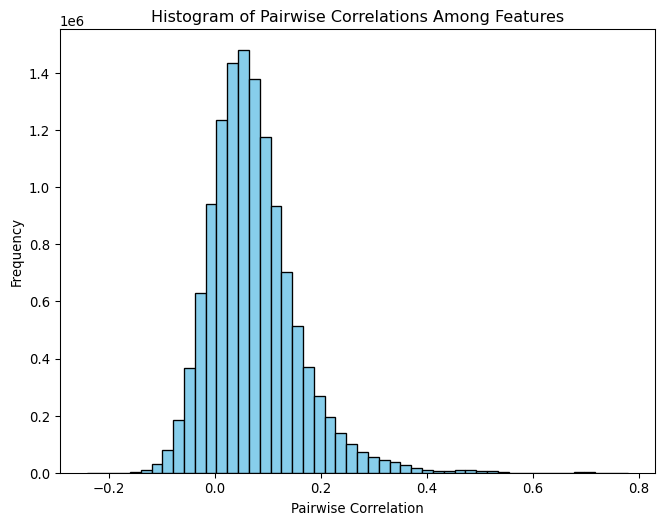

In [6]:
# Compute the pairwise correlation matrix.
# Set rowvar=False because features are columns.

corr_matrix = np.corrcoef(X_scaled, rowvar=False)

# Extract the lower-triangular part (excluding the diagonal)
# to get all unique pairwise correlations.

tril_indices = np.tril_indices_from(corr_matrix, k=-1)
corr_values = corr_matrix[tril_indices]

# Visualize the histogram of pairwise correlations.
plt.figure(figsize=(8, 6))
plt.hist(corr_values, bins=50, color='skyblue', edgecolor='black')
plt.xlabel("Pairwise Correlation")
plt.ylabel("Frequency")
plt.title("Histogram of Pairwise Correlations Among Features")
plt.show()

Visualizing the graph.

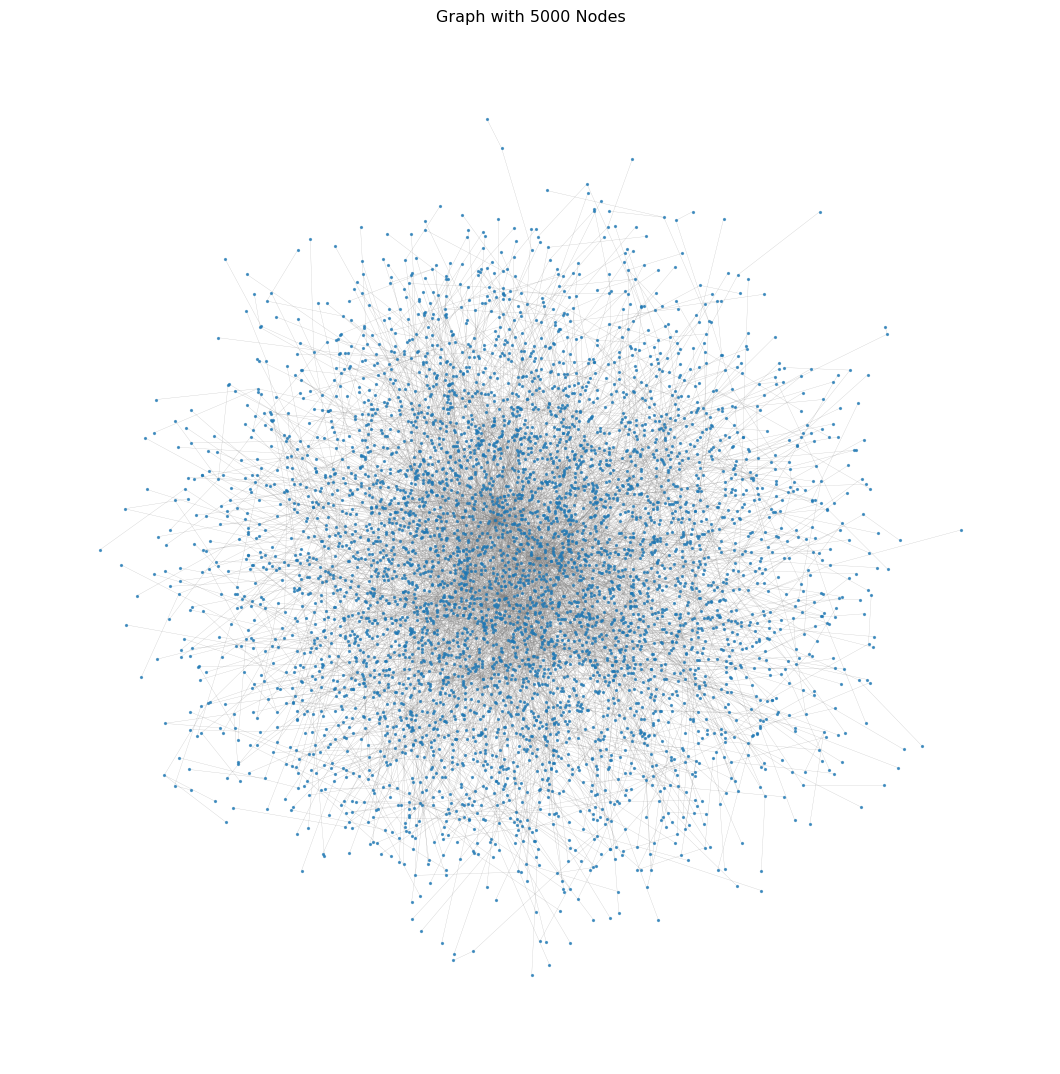

In [7]:
# Use a layout algorithm
pos = nx.spring_layout(G, k=0.15, iterations=20)

# Plot the graph
plt.figure(figsize=(14, 14))
nx.draw_networkx_nodes(G, pos, node_size=2, alpha=0.7)
nx.draw_networkx_edges(G, pos, width=0.2, alpha=0.5, edge_color='gray')
# Note: Avoid drawing labels for better clarity

plt.title('Graph with 5000 Nodes')
plt.axis('off')  # Turn off the axis
plt.show()

Analyzing node degrees and their frequencies.

In [8]:
from collections import Counter

# Calculate the degrees of all nodes
degrees = [degree for node, degree in G.degree()]

# Count the frequency of each degree
degree_count = Counter(degrees)

# Find the top 5 largest degrees
top_5_degrees = degree_count.most_common(5)

# Print the top 5 degrees and their frequencies
print("Top 5 largest degrees and their frequencies:")
for degree, frequency in top_5_degrees:
    print(f"Degree: {degree}, Frequency: {frequency}")

Top 5 largest degrees and their frequencies:
Degree: 1, Frequency: 3299
Degree: 2, Frequency: 857
Degree: 3, Frequency: 349
Degree: 4, Frequency: 167
Degree: 5, Frequency: 93

For a complementary view, looking at the frequencies of the nodes with
the largest degrees.

In [9]:
# Sort the degrees in descending order and find the top 5 unique degrees
top_5_degrees = sorted(set(degrees), reverse=True)[:5]

# Print the top 5 largest degrees and their frequencies
print("Top 5 largest degrees and the number of nodes with those degrees:")
for degree in top_5_degrees:
    print(f"Degree: {degree}, Frequency: {degree_count[degree]}")

Top 5 largest degrees and the number of nodes with those degrees:
Degree: 206, Frequency: 1
Degree: 60, Frequency: 2
Degree: 57, Frequency: 1
Degree: 46, Frequency: 1
Degree: 42, Frequency: 1

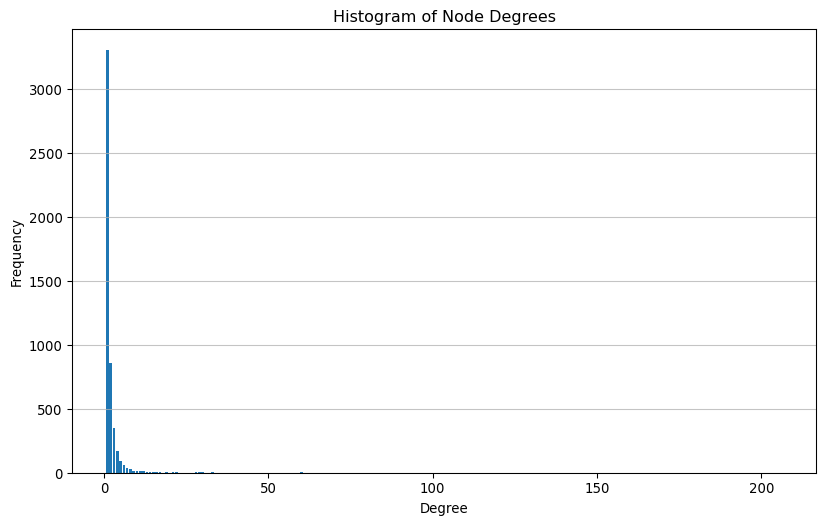

In [10]:
# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=range(min(degrees), max(degrees) + 2), align='left', rwidth=0.8)
plt.title('Histogram of Node Degrees')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Deep Learning

In [11]:
### Parameters

n = 4000     # number of samples
p = 5000     # number of features (adjust to 5000 for full-scale simulation)
p0 = 40      # number of true predictors
s0 = 0.0     # proportion of singletons (0.0, 0.5, 1.0)

model_seed=42

In [12]:
### Generate data

# Generate the synthetic data
X, y, true_idx, A, R, G, b, b0, prob = generate_synthetic_data(n=n, p=p, p0=p0, s0=s0, random_seed=model_seed)

print(f"n={n}, number of positive {np.sum(y)}")

n=4000, number of positive 1728

In [13]:
split_seed = 77

# Split the data: 80% train, 10% validation, 10% test.

X_train, X_temp, y_train, y_temp = train_test_split(X, y, stratify=y, test_size=0.2, random_state=split_seed)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_temp = scaler.transform(X_temp)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, stratify=y_temp, test_size=0.5, random_state=split_seed)

In [14]:
def create_baseline_model(input_dim, hidden_dims):
    """
    Creates a baseline deep feedforward network with the same architecture
    as the graph-embedded model but without domain-specific graph information.

    Architecture:
      - Input layer of dimension 'input_dim'.
      - Additional Dense hidden layers as specified in hidden_dims.
      - Final output layer with a single neuron for binary classification.

    Args:
      input_dim (int): Number of input features.
      hidden_dims (list of int): List of hidden layer sizes after the first layer.

    Returns:
      model (tf.keras.Model): The baseline Keras model.
    """

    inputs = keras.Input(shape=(input_dim,))

    # First hidden layer with L1 and L2 regularization

    x = layers.Dense(
        hidden_dims[0],
        activation="relu",
        kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-5),
        name="baseline_fc1"
    )(inputs)

    # Additional hidden layers

    for i, dim in enumerate(hidden_dims[1:], start=2):
        x = layers.Dense(
            dim, activation="relu", 
            kernel_regularizer=regularizers.l2(1e-5), 
            name=f"baseline_fc{i}"
        )(x)

    # Final output layer (binary classification)
    
    outputs = layers.Dense(1, activation="sigmoid", name="output")(x)

    return keras.Model(inputs=inputs, outputs=outputs)

In [15]:
hidden_dims = [1]
epochs = 750
batch_size = 128

In [16]:
baseline_model = create_baseline_model(input_dim=p, hidden_dims=hidden_dims)
baseline_model.compile(optimizer=keras.optimizers.Adam(3e-4), loss='binary_crossentropy', metrics=['accuracy'])
baseline_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type) ┃ Output Shape ┃ Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 ( InputLayer ) │ ( None , 5000 ) │ 0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ baseline_fc1 ( Dense ) │ ( None , 1 ) │ 5,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output ( Dense ) │ ( None , 1 ) │ 2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

Total params: 5,003 (19.54 KB)

Trainable params: 5,003 (19.54 KB)

Non-trainable params: 0 (0.00 B)

In [17]:
# Train the baseline model.

history_baseline = baseline_model.fit(X_train, y_train, 
                                      validation_data=(X_val, y_val),
                                      epochs=epochs, 
                                      batch_size=batch_size,
                                      verbose=0)

              precision    recall  f1-score   support

           0       0.93      0.94      0.94       227
           1       0.92      0.91      0.92       173

    accuracy                           0.93       400
   macro avg       0.93      0.93      0.93       400
weighted avg       0.93      0.93      0.93       400


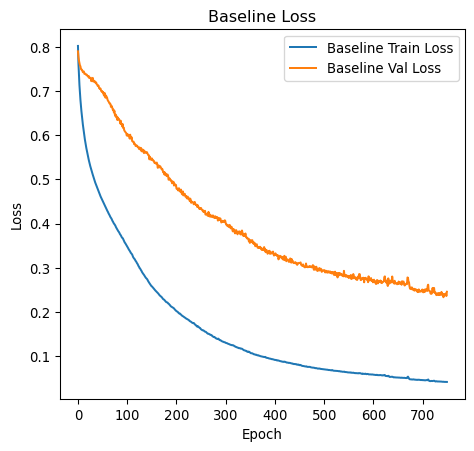

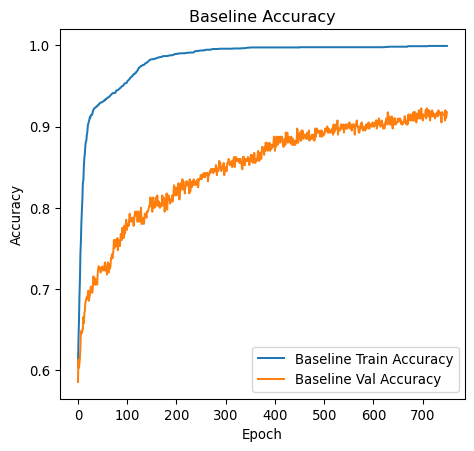

In [18]:
# Plot training and validation loss.

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_baseline.history['loss'], label='Baseline Train Loss')
plt.plot(history_baseline.history['val_loss'], label='Baseline Val Loss')
plt.title("Baseline Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot training and validation loss.
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_baseline.history['accuracy'], label='Baseline Train Accuracy')
plt.plot(history_baseline.history['val_accuracy'], label='Baseline Val Accuracy')
plt.title("Baseline Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

y_pred = (baseline_model.predict(X_test, verbose=0) > 0.5).astype(int)

print(classification_report(y_test, y_pred))

The following extracts the weights from the hidden layer, subsequently
revealing that 20 out of the 40 attributes utilized in model
construction are among the top 40 highest weights. This exemplifies the
efficacy of $l_1$ regularization in feature selection. The model
achieves an accuracy of 93% when regularization is applied, compared to
an accuracy of 78% in the absence of regularization.

In [19]:
W, b = baseline_model.get_layer("baseline_fc1").get_weights()
w_0 = W[:, 0]
sorted_feats = np.argsort(-w_0)
ranks = np.empty_like(sorted_feats)
ranks[sorted_feats] = np.arange(1, len(w_0) + 1)
print(ranks[true_idx])
print(sum(ranks[true_idx]<40))

[3067 4996    1 4983 1705 4988 4984 4989 4985    4 4986   15 4999 4995
 4991 4994 5000    8    6    9 4998 4987 4992   11 4997    5    3   19
   20    7 4993   17   12   13   14    2   18   16 4990   10]
20